In [1]:
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed:
%autoreload 2

In [3]:
# General imports
from pathlib import Path
import numpy as np
import xarray as xr
from numbers import Number

# Plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
plt.rcParams["figure.figsize"] = (20, 10)


# power_perceiver imports
from power_perceiver.dataset import NowcastingDataset
from power_perceiver.consts import BatchKey
from power_perceiver.data_loader import HRVSatellite, PV
from power_perceiver.xr_batch_processor import SelectPVSystemsNearCenterOfImage
from power_perceiver.data_loader.data_loader import NumpyBatch

from power_perceiver.np_batch_processor.encode_space_time import get_spatial_and_temporal_fourier_features
from power_perceiver.np_batch_processor.encode_space_time import compute_fourier_features
from power_perceiver.np_batch_processor.encode_space_time import _rescale_coords_for_all_dims_to_approx_0_to_1
from power_perceiver.np_batch_processor.encode_space_time import _rescale_coords_for_single_dim_to_approx_0_to_1
from power_perceiver.np_batch_processor.encode_space_time import _get_min_per_example



In [4]:
DATA_PATH = Path("~/dev/ocf/power_perceiver/data_for_testing/").expanduser()
assert DATA_PATH.exists()

In [5]:
dataset = NowcastingDataset(
    data_path=DATA_PATH,
    data_loaders=[HRVSatellite(), PV()],
    xr_batch_processors=[SelectPVSystemsNearCenterOfImage()],
)

In [6]:
BATCH_IDX = 0
np_batch = dataset[BATCH_IDX]

In [7]:
rescaled_coords = _rescale_coords_for_all_dims_to_approx_0_to_1(
    np_batch=np_batch,
    lengths=dict(x_osgb=120_000, y_osgb=200_000, time_utc=60*5*31)
    )

In [8]:
rescaled_coords['pv_x_osgb_rescaled'].dtype

dtype('float32')

In [9]:
{key: np.nanmin(arr) for key, arr in rescaled_coords.items()}

{'hrvsatellite_x_osgb_rescaled': 0.0,
 'pv_x_osgb_rescaled': 0.18888229,
 'hrvsatellite_y_osgb_rescaled': 0.0,
 'pv_y_osgb_rescaled': 0.025174843,
 'hrvsatellite_time_utc_rescaled': 0.0,
 'pv_time_utc_rescaled': 0.0}

In [10]:
{key: np.nanmax(arr) for key, arr in rescaled_coords.items()}

{'hrvsatellite_x_osgb_rescaled': 0.8786345,
 'pv_x_osgb_rescaled': 0.5974703,
 'hrvsatellite_y_osgb_rescaled': 0.91288346,
 'pv_y_osgb_rescaled': 0.7325675,
 'hrvsatellite_time_utc_rescaled': 0.9772043,
 'pv_time_utc_rescaled': 0.9772043}

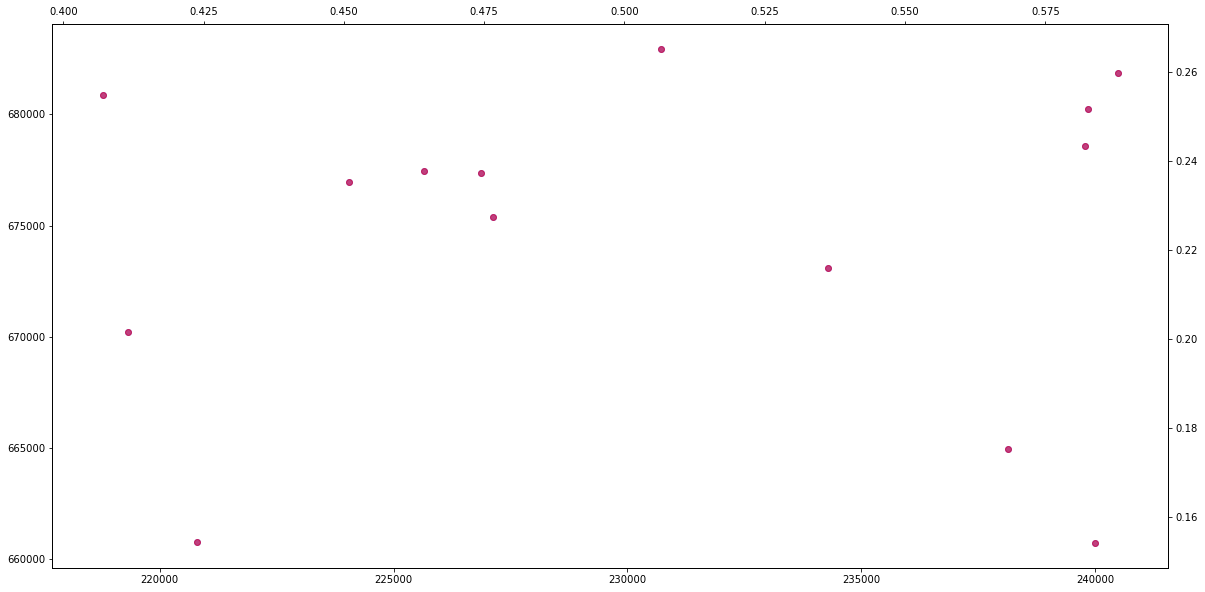

In [11]:
EXAMPLE_IDX = 0

osgb_ax = plt.axes()

osgb_ax.scatter(
    x=np_batch[BatchKey.pv_x_osgb][EXAMPLE_IDX],
    y=np_batch[BatchKey.pv_y_osgb][EXAMPLE_IDX],
    color="blue",
    alpha=0.5,
)

rescaled_ax = osgb_ax.twinx().twiny()

rescaled_ax.scatter(
    x=rescaled_coords['pv_x_osgb_rescaled'][EXAMPLE_IDX],
    y=rescaled_coords['pv_y_osgb_rescaled'][EXAMPLE_IDX],
    color="red", 
    alpha=0.5,
)

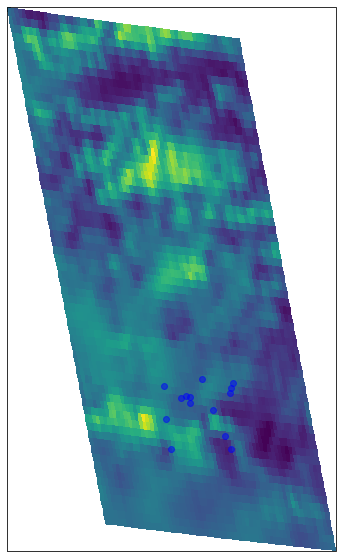

In [12]:

osgb_ax = plt.axes(projection=ccrs.OSGB(approx=False))

osgb_ax.pcolormesh(
    np_batch[BatchKey.hrvsatellite_x_osgb][EXAMPLE_IDX],
    np_batch[BatchKey.hrvsatellite_y_osgb][EXAMPLE_IDX],
    np_batch[BatchKey.hrvsatellite][EXAMPLE_IDX, 0, 0],   
)

osgb_ax.scatter(
    x=np_batch[BatchKey.pv_x_osgb][EXAMPLE_IDX],
    y=np_batch[BatchKey.pv_y_osgb][EXAMPLE_IDX],
    color="blue",
    alpha=0.5,
)

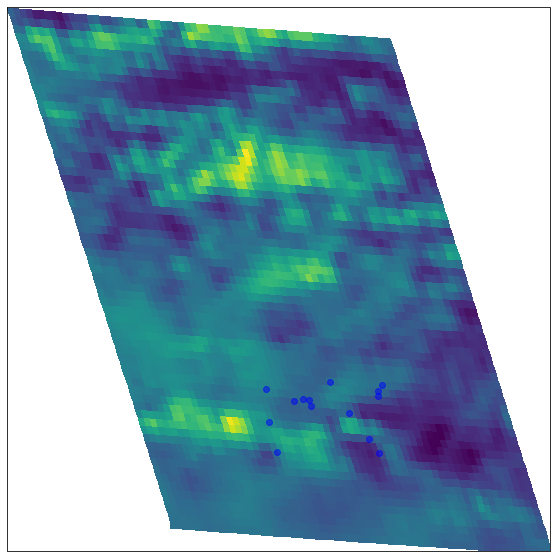

In [13]:
rescaled_axes = plt.axes(projection=ccrs.OSGB(approx=False))

rescaled_axes.pcolormesh(
    rescaled_coords["hrvsatellite_x_osgb_rescaled"][EXAMPLE_IDX],
    rescaled_coords["hrvsatellite_y_osgb_rescaled"][EXAMPLE_IDX],
    np_batch[BatchKey.hrvsatellite][EXAMPLE_IDX, 0, 0],   
)

rescaled_axes.scatter(
    x=rescaled_coords["pv_x_osgb_rescaled"][EXAMPLE_IDX],
    y=rescaled_coords["pv_y_osgb_rescaled"][EXAMPLE_IDX],
    color="blue",
    alpha=0.5,
)

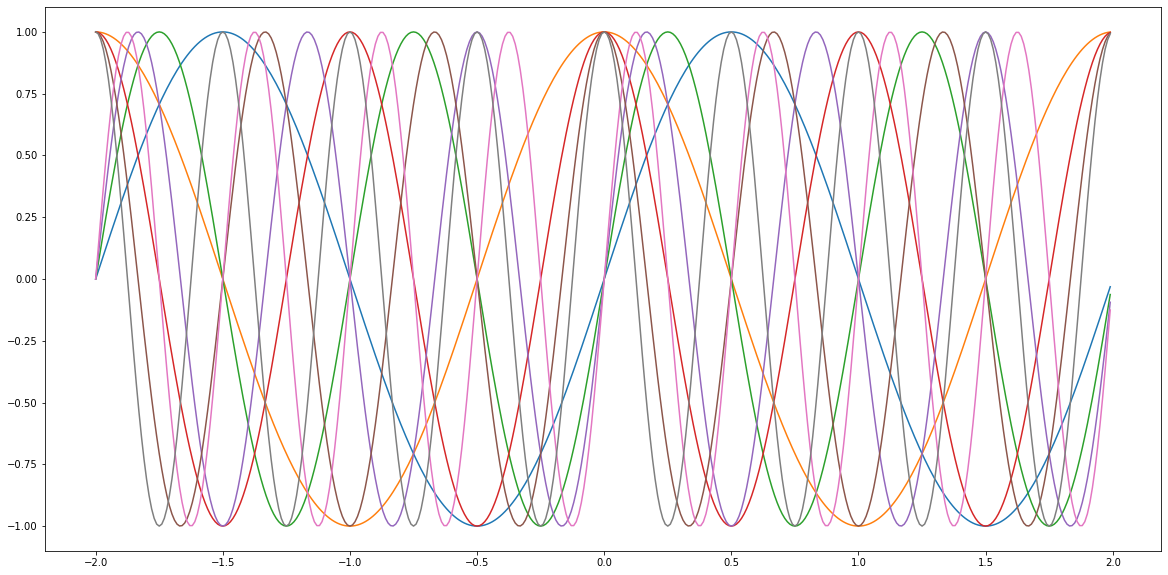

In [14]:
# Test!
test_array = np.arange(start=-2, stop=2, step=0.01, dtype=np.float32)
fourier_features = compute_fourier_features(test_array.reshape((1, -1)))
plt.plot(test_array, fourier_features[0]);

In [15]:
%%time
np_batch = get_spatial_and_temporal_fourier_features(
    np_batch=np_batch,
    lengths=dict(x_osgb=120_000, y_osgb=200_000, time_utc=60*5*31),
)

CPU times: user 24.1 ms, sys: 3.79 ms, total: 27.9 ms
Wall time: 26.7 ms


In [16]:
[key.name for key in np_batch.keys()]

['hrvsatellite',
 'hrvsatellite_time_utc',
 'hrvsatellite_x_osgb',
 'hrvsatellite_y_osgb',
 'pv',
 'pv_system_row_number',
 'pv_id',
 'pv_capacity_wp',
 'pv_mask',
 'pv_time_utc',
 'pv_x_osgb',
 'pv_y_osgb',
 'hrvsatellite_x_osgb_fourier',
 'pv_x_osgb_fourier',
 'hrvsatellite_y_osgb_fourier',
 'pv_y_osgb_fourier',
 'hrvsatellite_time_utc_fourier',
 'pv_time_utc_fourier']

In [17]:
np_batch[BatchKey.hrvsatellite_x_osgb_fourier].shape

(32, 64, 64, 8)

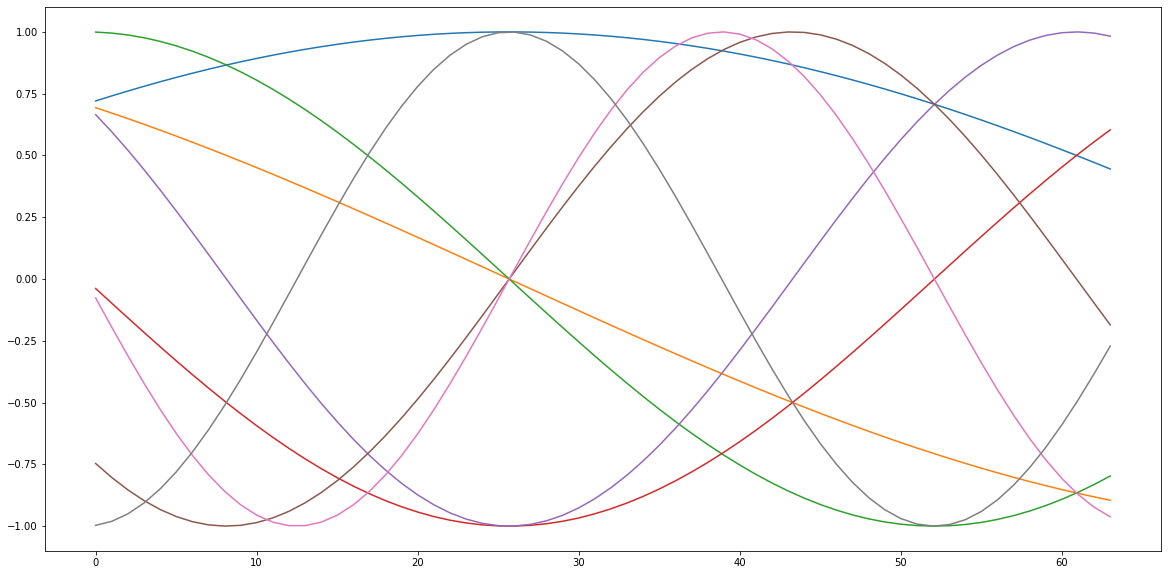

In [18]:
plt.plot(np_batch[BatchKey.hrvsatellite_x_osgb_fourier][0, 0]);

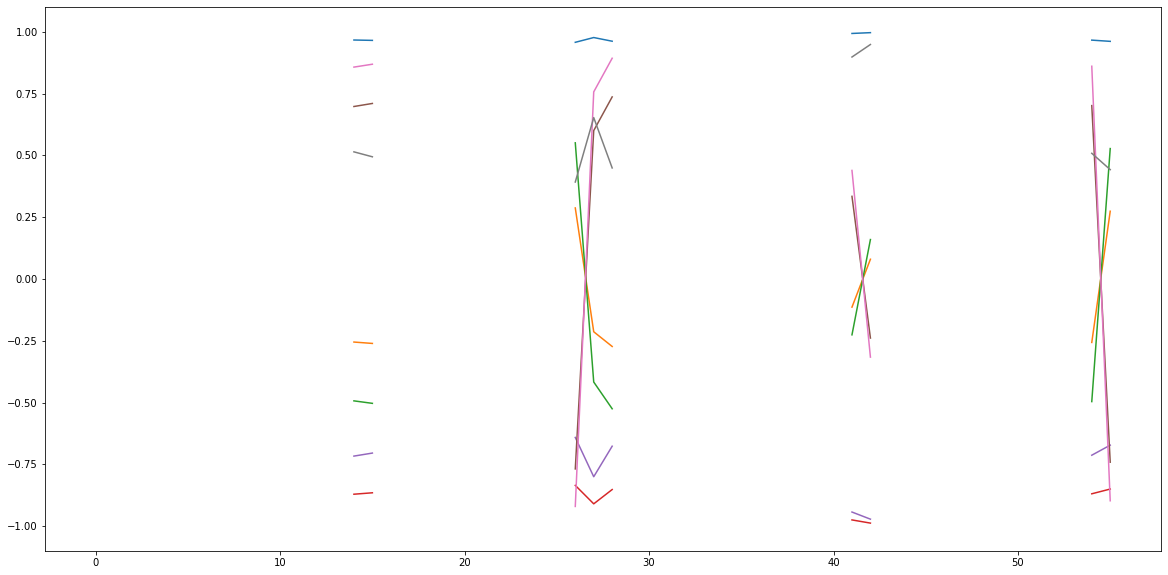

In [19]:
plt.plot(np_batch[BatchKey.pv_x_osgb_fourier][0]);

In [20]:
np_batch[BatchKey.pv_x_osgb_fourier].shape

(32, 128, 8)